# Lecture 3 Sector-coupling

## PV, CHP, Bio, Natural-gas, District heating

### 1)Import Packages

In [115]:
import pypsa
import pandapower as pp
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import warnings
import subprocess
from shapely.errors import ShapelyDeprecationWarning
import logging

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
logging.getLogger("pypsa.pf").setLevel(logging.WARNING)
plt.rc("figure", figsize=(10, 8))

### 2)Create a network and set Snapshots

In [116]:
# Create a new PyPSA network
network = pypsa.Network()
network.set_snapshots(range(1))  # Solve for a year 365*24
solver='highs'

### 3)Add Buses

In [117]:
bus= pd.read_csv('buses.csv',header=0)
network.madd(
    "Bus",
    names= bus.bus,
    v_nom=list(bus.v_nom),
    carrier=list(bus.carrier),
    #x=list(bus.x),
    #y=list(bus.y),
)
network.buses

,v_nom,carrier,type,x,y,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,
ele_bus,20.0,AC,,0.0,0.0,,1.0,0.0,inf,PQ,,
heat_bus,1.0,heat,,0.0,0.0,,1.0,0.0,inf,PQ,,
H2_bus,1.0,hydrogen,,0.0,0.0,,1.0,0.0,inf,PQ,,
gas_bus,1.0,gas,,0.0,0.0,,1.0,0.0,inf,PQ,,
biomass_bus,1.0,biomass,,0.0,0.0,,1.0,0.0,inf,PQ,,


### 4)Add generators

In [118]:
# Read excel file which contains Non renewable generators data
generators=pd.read_csv('generators.csv',header=0)
network.madd(
    "Generator",
    names= generators.generator,
    bus=list(generators.bus),
    carrier=list(generators.carrier),
    p_nom=list(generators.p_nom),
    p_nom_extendable=list(generators.p_nom_extendable),
    marginal_cost=list(generators.marginal_cost),
    efficiency=list(generators.efficiency)
) 
network.generators

,bus,carrier,p_nom,p_nom_extendable,marginal_cost,efficiency,control,type,p_nom_mod,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,q_set,sign,marginal_cost_quadratic,build_year,lifetime,capital_cost,committable,start_up_cost,shut_down_cost,stand_by_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
coal,ele_bus,coal,50.0,False,50.0,0.35,PQ,,0.0,0.0,inf,0.0,1.0,0.0,0.0,1.0,0.0,0,inf,0.0,False,0.0,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
biomass,ele_bus,biomass,30.0,True,100.0,0.30,PQ,,0.0,0.0,inf,0.0,1.0,0.0,0.0,1.0,0.0,0,inf,0.0,False,0.0,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
wind,ele_bus,wind,20.0,False,0.0,0.30,PQ,,0.0,0.0,inf,0.0,1.0,0.0,0.0,1.0,0.0,0,inf,0.0,False,0.0,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


### 5)Add load

In [119]:
# Read excel file which contains Non renewable generators data
load=pd.read_csv('loads.csv',header=0)
network.madd(
    "Load",
    names= load.bus,
    bus=list(load.bus),
    p_set=list(load.p_set),
)
network.loads

,bus,p_set,carrier,type,q_set,sign
Load,,,,,,
ele_bus,ele_bus,120.0,,,0.0,-1.0
heat_bus,heat_bus,100.0,,,0.0,-1.0
H2_bus,H2_bus,20.0,,,0.0,-1.0


### 6)Add links

In [120]:
links = pd.read_csv('links.csv', header=0)
network.madd(
    "Link",
    names=links.name,
    bus0=list(links.bus0),
    bus1=list(links.bus1),
    bus2=list(links.bus2),
    p_nom=list(links.p_nom),
    p_nom_extendable=list(links.p_nom_extendable),
    efficiency=list(links.efficiency),
    efficiency2=list(links.efficiency2),
    capital_cost=list(links.capital_cost),
)
network.links

,bus0,bus1,bus2,p_nom,p_nom_extendable,efficiency,efficiency2,capital_cost,type,carrier,build_year,lifetime,p_nom_mod,p_nom_min,p_nom_max,p_set,p_min_pu,p_max_pu,marginal_cost,marginal_cost_quadratic,stand_by_cost,length,terrain_factor,committable,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Link,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
heat_pump,ele_bus,heat_bus,,10.0,True,3.0,0.0,900.0,,,0,inf,0.0,0.0,inf,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
electrolyzer,ele_bus,H2_bus,,10.0,True,0.8,0.0,150.0,,,0,inf,0.0,0.0,inf,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
gas_boiler,gas_bus,heat_bus,,10.0,True,0.9,0.0,300.0,,,0,inf,0.0,0.0,inf,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
CHP,gas_bus,ele_bus,heat_bus,10.0,True,0.3,0.3,1400.0,,,0,inf,0.0,0.0,inf,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
OCGT,gas_bus,ele_bus,,10.0,True,0.4,0.0,600.0,,,0,inf,0.0,0.0,inf,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


### 7)Add carriers

In [121]:
carriers = pd.read_csv('carrier.csv', header=0)
network.madd(
    "Carrier",
    names=carriers.carrier,
    co2_emissions=list(carriers.co2_emissions),
    nice_name=list(carriers.carrier),
)

Index(['gas', 'coal', 'wind', 'biomass'], dtype='object', name='carrier')

### 8)Storages

In [122]:
stores = pd.read_csv('stores.csv', header=0)
network.madd(
    "Store",
    names=stores.name,
    e_initial=list(stores.e_initial),
    e_nom=list(stores.e_nom),
    marginal_cost=list(stores.marginal_cost),
    bus=list(stores.bus),
    e_cyclic=list(stores.e_cyclic),
    e_nom_extendable=list(stores.e_nom_extendable),
)
network.stores

,e_initial,e_nom,marginal_cost,bus,e_cyclic,e_nom_extendable,type,carrier,e_nom_mod,e_nom_min,e_nom_max,e_min_pu,e_max_pu,e_initial_per_period,e_cyclic_per_period,p_set,q_set,sign,marginal_cost_quadratic,capital_cost,standing_loss,build_year,lifetime,e_nom_opt
Store,,,,,,,,,,,,,,,,,,,,,,,,
water tank,1000000.0,1000000.0,10.0,heat_bus,True,True,,,0.0,0.0,inf,0.0,1.0,False,True,0.0,0.0,1.0,0.0,0.0,0.0,0,inf,0.0
gas_store,1000000.0,1000000.0,0.0,gas_bus,True,True,,,0.0,0.0,inf,0.0,1.0,False,True,0.0,0.0,1.0,0.0,0.0,0.0,0,inf,0.0
hydrogen_store,1000.0,1000.0,20.0,H2_bus,True,True,,,0.0,0.0,inf,0.0,1.0,False,True,0.0,0.0,1.0,0.0,0.0,0.0,0,inf,0.0


storage_units = pd.read_csv('storage_units.csv', header=0)
network.madd(
    "Storage_units",
    names=stores.name,
    e_initial=list(stores.e_initial),
    e_nom=list(stores.e_nom),
    marginal_cost=list(stores.marginal_cost),
    bus=list(stores.bus),
    e_cyclic=list(stores.e_cyclic),
    e_nom_extendable=list(stores.e_nom_extendable),
)
network.stores

### 9)Global constraints

In [123]:
network.add("GlobalConstraint", "co2_limit", sense="<=", constant=10000.0)

In [124]:
network.optimize()

{'biomass_bus'}
{'biomass_bus'}
INFO:linopy.model: Solve problem using Glpk solver
INFO:linopy.io: Writing time: 0.08s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 24 primals, 39 duals
Objective: 1.36e+04
Solver model: not available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp C:\Users\par19744\AppData\Local\Temp\linopy-problem-12t4nitd.lp --output
 C:\Users\par19744\AppData\Local\Temp\linopy-solve-3h4td2zc.sol
Reading problem data from 'C:\Users\par19744\AppData\Local\Temp\linopy-problem-12t4nitd.lp'...
39 rows, 24 columns, 61 non-zeros
214 lines were read
GLPK Simplex Optimizer 5.0
39 rows, 24 columns, 61 non-zeros
Preprocessing...
~     0: obj =   1.358333333e+04  infeas =  0.000e+00
OPTIMAL SOLUTION FOUND BY LP PREPROCESSOR
Time used:   0.0 secs
Memory used: 0.0 Mb (48420 bytes)
Writing basic solution to 'C:\Users\par19744\AppData\Local\Temp\linopy-solve-3h4td2zc.sol'...


('ok', 'optimal')

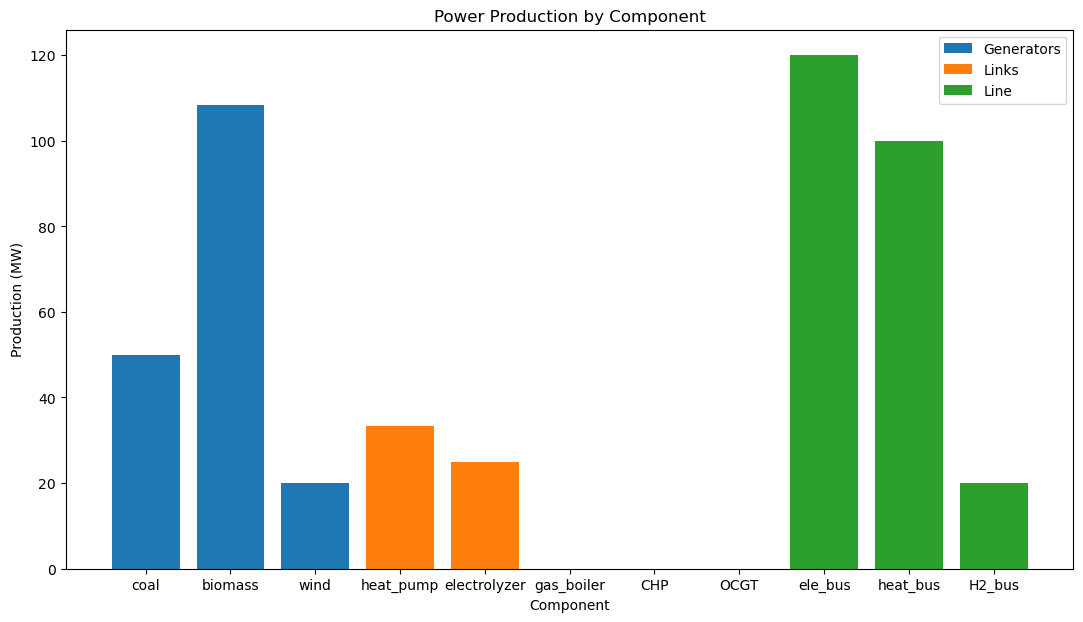

In [125]:
# Your DataFrame df
df = pd.concat([network.generators_t.p.loc[0],
        network.links_t.p0.loc[0],
        network.loads_t.p.loc[0],
    ],
    keys=["Generators", "Links", "Line"],
    names=["Component", "index"],
).reset_index(name="Production")

# Plotting using PyPSA
fig, ax = plt.subplots(figsize=(13, 7))

# Plot generators
df_generators = df[df["Component"] == "Generators"]
ax.bar(df_generators["index"], df_generators["Production"], label="Generators")

# Plot links
df_links = df[df["Component"] == "Links"]
ax.bar(df_links["index"], df_links["Production"], label="Links")

# Plot loads
df_loads = df[df["Component"] == "Line"]
ax.bar(df_loads["index"], df_loads["Production"], label="Line")

# Customize the plot
ax.set_xlabel("Component")
ax.set_ylabel("Production (MW)")
ax.set_title("Power Production by Component")
ax.legend()

# Show the plot
plt.show()
